In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import io
import imageio
import cv2
import sys
from ipywidgets import widgets, HBox
from skimage.metrics import structural_similarity as ssim


import pickle 
import torchvision
from torch.autograd import Variable
from torch import Tensor

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
Radar = np.load('new_radar_20_128fr_cleaned.npy')

In [4]:
Radar.resize((5802, 10, 128, 128))

In [5]:
print(type(Radar))
print(Radar.shape)
print(Radar.itemsize)

<class 'numpy.ndarray'>
(5802, 10, 128, 128)
1


In [6]:
np.random.shuffle(Radar)
print(Radar.shape)

(5802, 10, 128, 128)


In [7]:
# Train, Test, Validation splits
train_data = Radar[:2000]         
val_data = Radar[2000:2100]       
test_data = Radar[2100:2200]     

def collate(batch):

    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)     
    batch = batch / 255.0                        
    batch = batch.to(device)                     

    # Randomly pick 10 frames as input, 11th frame is target 
    x = 4
    return batch[:,:,x-4:x], batch[:,:,x:8]     


# Training Data Loader
train_loader = DataLoader(train_data, shuffle=True, 
                        batch_size=4, collate_fn=collate)

# Validation Data Loader
val_loader = DataLoader(val_data, shuffle=True, 
                        batch_size=4, collate_fn=collate)

In [8]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
    
    def forward(self, x):
        #print(x.shape)
        y = self.conv1(x)
        #print('surpassed this')
        return self.conv2(self.relu(y))


class Encoder(nn.Module):
    def __init__(self, chs=(4,64,128,256)):
        super().__init__()
        l = [Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]
        #print(l)
        self.enc_blocks = nn.ModuleList(l)
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            #print('enc block output:', x.shape)
            ftrs.append(x)
            #print('ftrs shape:', x.shape)
            x = self.pool(x)
            #print('after pool:', x.shape)
        return ftrs


class Decoder(nn.Module):
    #def __init__(self, chs=(1024, 512, 256, 128, 64)):
    def __init__(self, chs=(256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        #print(len(x), len(encoder_features))
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            #print('forward to crop x and enc:', x.shape, encoder_features[i].shape)
            enc_ftrs = self.crop(encoder_features[i], x)
            #print('forward shapes of x and enc_fts:', x.shape, enc_ftrs.shape)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        #print('crop output shape', enc_ftrs.shape)
        return enc_ftrs


class Generator(nn.Module):
    def __init__(self, enc_chs=(4,64,128,256), dec_chs=(256, 128, 64), num_class=4, retain_dim=False, out_sz=(128,128)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        #for ftr in enc_ftrs: print(ftr.shape)
        #print('decoder input:', enc_ftrs[::-1][0].shape, enc_ftrs[::-1][1:].shape)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        #print('decoder output:', out.shape)
        out      = self.head(out)
        #print('shape after head:', out.shape)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [9]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=4):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(4 * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        #print(img_input.shape)
        return self.model(img_input)




In [10]:


# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-4)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()
num_epochs = 10

In [11]:
def calculate_psnr(target, output):
    """
    Calculate Peak Signal To Noise Ratio
    Input: torch tensor of shape (m, C, H, W)
    Output: average of PSTR for that batch
    """
    
    m, C, H, W = target.shape
    sum_psnr = 0 
    
    for i in range(m):
        output[i] = torch.clamp(output[i], min=0.0, max=1.0)
        mse = torch.sum((target[i] - output[i])**2)/(C*H*W)
        psnr =  -10*torch.log10(mse)
        sum_psnr += psnr
        
    return sum_psnr

In [12]:
patch = (1, 128 // 2 ** 4, 128 // 2 ** 4)
lambda_pixel = 100

In [13]:
epi=0
generator_tr_loss = []
discriminator_tr_loss = []
va_loss = []
ep=[]
for epoch in range(1, num_epochs+1):
    epi+=1
    ep.append(epi)
    psnr_train = 0
    psnr_val =0
    ssim_train = 0
    ssim_val = 0  
    generator.train()
    discriminator.train()
    
    generator_loss = 0
    discriminator_loss = 0
    for batch_num, (input, target) in enumerate(train_loader, 1):  

        # Model inputs
        input = torch.squeeze(input, axis=1).to(device)
        target = torch.squeeze(target, axis=1).to(device)
        real_A = Variable(input.type(Tensor)).to(device)
        real_B = Variable(target.type(Tensor)).to(device)
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False).to(device)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False).to(device)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # GAN loss
        fake_B = generator(real_A)

        pred_fake = discriminator(fake_B, real_A)

        loss_GAN = criterion_GAN(pred_fake, valid)
        # Pixel-wise loss
        
        loss_pixel = criterion_pixelwise(fake_B, real_B)
        
        loss_G = loss_GAN + lambda_pixel * loss_pixel
        generator_loss+=loss_G.item()
        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(real_B, real_A)
        loss_real = criterion_GAN(pred_real, valid)
        # Fake loss
        pred_fake = discriminator(fake_B.detach(), real_A)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)
        discriminator_loss+=loss_D.item()
        loss_D.backward()
        optimizer_D.step()
        psnr_train+=calculate_psnr(real_B, fake_B)
        ot = fake_B.flatten().cpu()
        tt = real_B.flatten().cpu()
        ssim_train+=ssim(ot.detach().numpy(), tt.detach().numpy(),data_range=1.0)

    discriminator_loss /= len(train_loader.dataset) 
    generator_loss /= len(train_loader.dataset) 
    psnr_train /= len(train_loader.dataset) 
    ssim_train/=len(train_loader.dataset)
    generator_tr_loss.append(generator_loss)
    discriminator_tr_loss.append(discriminator_loss)
    
    val_loss = 0                                                 
    generator.eval()                                                   
    with torch.no_grad():                                          
        for input, target in val_loader:  
            input = np.squeeze(input, axis=1).to(device)
            target = torch.squeeze(target, axis=1).to(device)
            real_A = Variable(input.type(Tensor)).to(device)
            real_B = Variable(target.type(Tensor)).to(device)
            output = generator(real_A)   
            loss = criterion_pixelwise(output, target)   
            val_loss += loss.item()  
            psnr_val+=calculate_psnr(target, output)
            ot = output.flatten().cpu()
            tt = target.flatten().cpu()
            ssim_val+=ssim(ot.detach().numpy(), tt.detach().numpy(),data_range=1.0)
    val_loss /= len(val_loader.dataset)      
    psnr_val/= len(val_loader.dataset) 
    ssim_val/=len(val_loader.dataset)
    va_loss.append(val_loss)
    print("Epoch:{} generator Training Loss:{:.10f} discriminator Training Loss:{:.6f} psnr_train:{} ssim_train:{:.6f} generator Validation Loss:{:.6f} psnr_val:{} ssim_val:{:.6f}\n".format(
        epoch, generator_loss, discriminator_loss, psnr_train, ssim_train, val_loss, psnr_val, ssim_val))
    

/tmp/ipykernel_1537739/1168816471.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  batch = torch.tensor(batch).unsqueeze(1)


Epoch:1 generator Training Loss:0.2488117416 discriminator Training Loss:0.043793 psnr_train:39.3536262512207 ssim_train:0.234918 generator Validation Loss:0.000685 psnr_val:40.734535217285156 ssim_val:0.242560

Epoch:2 generator Training Loss:0.2348372612 discriminator Training Loss:0.035115 psnr_train:40.16990280151367 ssim_train:0.240428 generator Validation Loss:0.001036 psnr_val:38.47720718383789 ssim_val:0.233568

Epoch:3 generator Training Loss:0.2210562593 discriminator Training Loss:0.042295 psnr_train:40.17762756347656 ssim_train:0.238929 generator Validation Loss:0.000758 psnr_val:41.05329132080078 ssim_val:0.241180

Epoch:4 generator Training Loss:0.2038124569 discriminator Training Loss:0.042973 psnr_train:40.810970306396484 ssim_train:0.241365 generator Validation Loss:0.000721 psnr_val:41.45228958129883 ssim_val:0.241658

Epoch:5 generator Training Loss:0.1885598375 discriminator Training Loss:0.045688 psnr_train:40.516822814941406 ssim_train:0.241546 generator Validatio

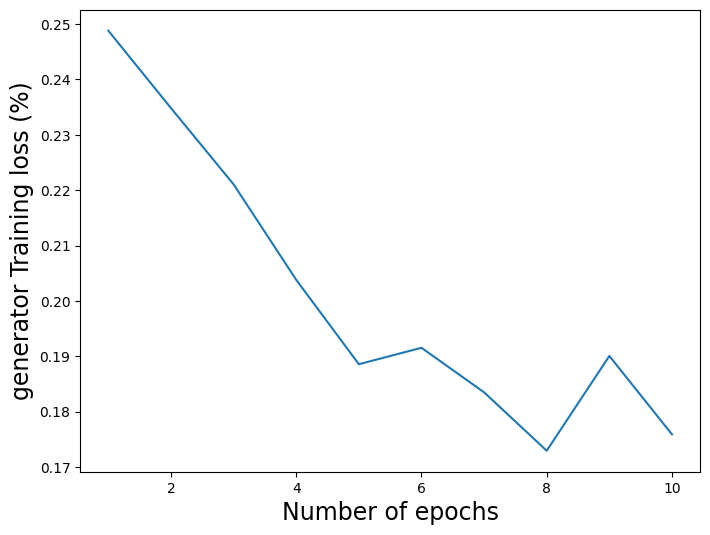

In [14]:
from matplotlib import pyplot as plt

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)
plt.xlabel("Number of epochs", fontsize = 17)
plt.ylabel("generator Training loss (%)", fontsize = 17)


plt.plot(ep, generator_tr_loss)
plt.show()

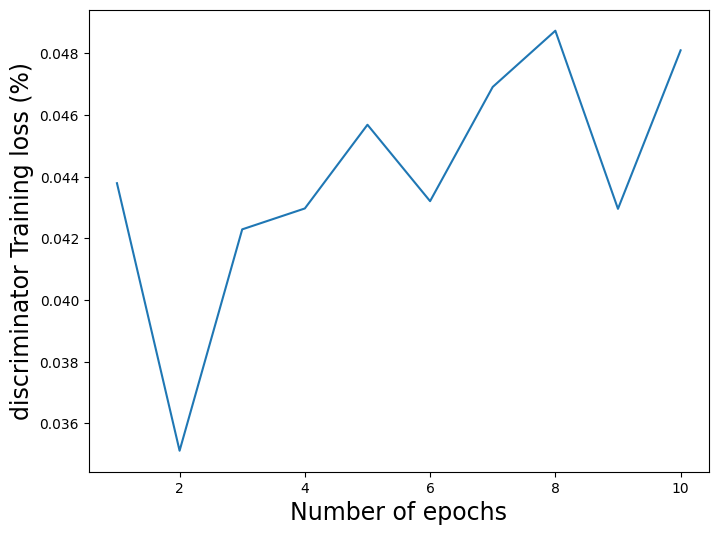

In [15]:
from matplotlib import pyplot as plt

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)
plt.xlabel("Number of epochs", fontsize = 17)
plt.ylabel("discriminator Training loss (%)", fontsize = 17)


plt.plot(ep, discriminator_tr_loss)
plt.show()

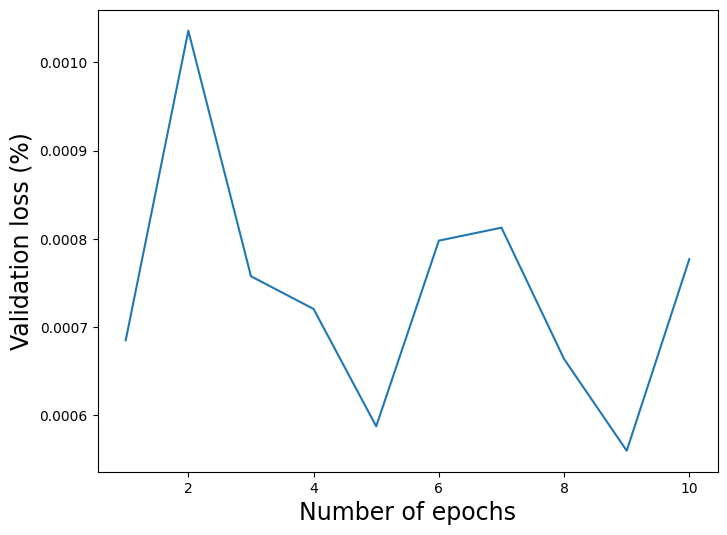

In [16]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)
plt.xlabel("Number of epochs", fontsize = 17)
plt.ylabel("Validation loss (%)", fontsize = 17)


plt.plot(ep, va_loss)
plt.show()

In [17]:
Pkl_Filename = "GANS_10_4seq_new_attempt3.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(generator, file)

In [18]:
with open('GANS_10_4seq_new_attempt3.pkl', 'rb') as file:  
    model = pickle.load(file)

In [19]:
def collate_test(batch):

    # Last 10 frames are target
    target = np.array(batch)[:,4:8]                     
    
    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)          
    batch = batch / 255.0                             
    batch = batch.to(device)                          
    return batch, target

# Test Data Loader
test_loader = DataLoader(test_data,shuffle=True, 
                         batch_size=3, collate_fn=collate_test)


# Get a batch
batch, target = next(iter(test_loader))

In [20]:
# Initialize output sequence
output = np.zeros(target.shape, dtype=np.uint8)

# Loop over timesteps
timestep=0
input = batch[:,:,timestep:timestep+4] 
input = torch.squeeze(input, axis=1)
last_out = generator(input).cpu()
output[:,:4]=(last_out>0.25)*255.0

In [21]:
for tgt, out in zip(target, output):       # Loop over samples
    
    # Write target video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, tgt, "GIF", fps = 2)    
        target_gif = gif.getvalue()

    # Write output video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, out, "GIF", fps = 2)    
        output_gif = gif.getvalue()

    display(HBox([widgets.Image(value=target_gif, height=400, width=400), 
                  widgets.Image(value=output_gif, height=400, width=400)]))

In [24]:
pickle.dump(model, open('modelcGAN.pkl', 'wb'))

In [25]:
test_loader_nu = DataLoader(test_data, shuffle=True, 
                        batch_size=1, collate_fn=collate)

ssim_test = 0
psnr_test = 0

model.eval()                                                   
with torch.no_grad():                                          
    for input, target in test_loader_nu:  
        input = np.squeeze(input, axis=1).to(device)
        target = torch.squeeze(target, axis=1).to(device)
        real_A = Variable(input.type(Tensor)).to(device)
        real_B = Variable(target.type(Tensor)).to(device)
        output = generator(real_A)  
        psnr_test+=calculate_psnr(target, output)
        ot = output.flatten().cpu()
        tt = target.flatten().cpu()
        ssim_test+=ssim(ot.detach().numpy(), tt.detach().numpy(),data_range=1.0)
psnr_test/= len(test_loader_nu.dataset)
ssim_test/=len(test_loader_nu.dataset)
print("PSNR for test dataset: {:.2f}", psnr_test)
print("SSIM for test dataset: {:.2f}", ssim_test)

PSNR for test dataset: {:.2f} tensor(39.2913)
SSIM for test dataset: {:.2f} 0.9694002026056522
